# Seeded inference for Table 1 metrics
GPU used: NVIDIA RTX 4000 Ada Generation (20GB)

In [1]:
from Nifty.method import *
from Nifty.networks import *
from Nifty.TO import TextureOptimization
import warnings; warnings.filterwarnings('ignore')

output_size = 512

## Nifty

In [ ]:
time_nifty=0
for j in tqdm(range(1,13)):
    im_name='%s.png'%j
    path=os.path.join('./comparison/eval_base/', im_name)
    img = Tensor_load(path)
    os.makedirs('./comparison/synthesis4metrics/%d/nifty'%j, exist_ok=True)
    for i in range(10):
        torch.manual_seed(i)
        tic= time.time()
        synth= Nifty(img,rs=1,T=15,k=5,patchsize=16,stride=4,octaves=4,size=(512,512),renoise=0.5,warmup=0,memory=True,show=False,save=False)
        time_nifty+=time.time()-tic
        imsave('./comparison/synthesis4metrics/%d/nifty/%d.png'%(j,i),synth)
print('Nifty time: %.2f s'%(time_nifty/120))

100%|██████████| 12/12 [01:32<00:00,  7.73s/it]

Nifty time: 0.70 s


## Texture Optimization

In [ ]:
time_kwatra=0
for j in tqdm(range(1,13)):
    im_name='%d.png'%j
    path=os.path.join('./comparison/eval_base/', im_name)
    img = Tensor_load(path)*.5+.5
    os.makedirs('./comparison/synthesis4metrics/%d/kwatra'%j, exist_ok=True)

    for i in range(10):
        torch.manual_seed(i)
        tic=time.time()
        synth,loss = TextureOptimization(img,N_subsampling=10000000, output_size=512)
        time_kwatra+=time.time()-tic
        imsave('./comparison/synthesis4metrics/%d/kwatra/%d.png'%(j,i),synth*2-1) 
print('Kwatra time: %.2f s'%(time_kwatra/120))

100%|██████████| 12/12 [04:00<00:00, 20.01s/it]

Kwatra time: 1.92 s


## U-Net approximation of the flow

In [3]:
I_actually_want_to_retrain_networks_rather_than_unziping = True

l_retrain=[]
for j in range(1,13):
    if not os.path.exists('comparison/models4metrics/%d.pth'%j):
        l_retrain.append(str(j))
if l_retrain!= []:
    print('Will train a network for images: %s'%','.join(l_retrain))


if l_retrain != [] and not I_actually_want_to_retrain_networks_rather_than_unziping:
    raise RuntimeError(
        "Networks are available in a zip file. Unzip them or set "
        "I_actually_want_to_retrain_networks_rather_than_unziping=True to retrain them."
    )

time_fm=0
train_time_fm=0
for j in tqdm(range(1,13),disable=False):
    im_name='%d.png'%j
    path=os.path.join('./comparison/eval_base/', im_name)
    img = Tensor_load(path)
    os.makedirs('./comparison/synthesis4metrics/%d/FM'%j, exist_ok=True)

    mu,sigma=img.mean(),img.std()
        
    flow_model = UNet(
        dim =16,
        dim_mults = (1, 2, 4, 4))

    if not os.path.exists('comparison/models4metrics/%d.pth'%j):
        if I_actually_want_to_retrain_networks_rather_than_unziping:
            os.makedirs('comparison/models4metrics', exist_ok=True)
            torch.manual_seed(0)
            tic=time.time()
            train_flow_net((img-mu)/sigma , flow_model,load=False,epochs=10000,show=False,save_name='comparison/models4metrics/%d.pth'%j)
            train_time_fm+=time.time()-tic
        else:
            print('Networks are available to unzip')

    flow_model.load_state_dict(torch.load('comparison/models4metrics/%d.pth'%j, map_location='cuda'),strict=False)
    flow_model.eval().cuda()


    for i in range(10):
        torch.manual_seed(i)
        tic=time.time()
        T=15
        with torch.no_grad():
            x=torch.randn(1,3,512,512).cuda()   
            times=torch.linspace(0, 1, steps=T+1).cuda()
            for it in range(T):
                t=times[it]
                t = t.to(device).unsqueeze(0)
                flow = flow_model(x,t.view(1))
                x=x+flow*(times[it+1]-times[it])
        synth_nn = x*sigma+mu
        time_fm+=time.time()-tic
        imsave('./comparison/synthesis4metrics/%d/FM/%d.png'%(j,i),synth_nn)
if l_retrain!=[]:
    print('FM training time: %d min and %d s'%(train_time_fm/len(l_retrain)//60,int(train_time_fm/len(l_retrain)%60)))
print('FM time: %.2f s'%(time_fm/120))


Will train a network for images: 1,2,3,4,5,6,7,8,9,10,11,12


100%|██████████| 12/12 [28:58<00:00, 144.91s/it]

FM training time: 2 min and 22 s
FM time: 0.13 s


# Generation of Fig. 2
Wasserstein 2 distance $\mathcal{W}_2$, depending on the number of $k$-NN and n the ratio $r$ of the exemplar data used. (computed on the red_peppers image)\
The distance is computed on non overalpping patches, allowing to only measures the quality of the approximation of the patch distribution by our approximation of the flow matching , without aggregation.

100%|██████████| 3/3 [01:55<00:00, 38.55s/it]


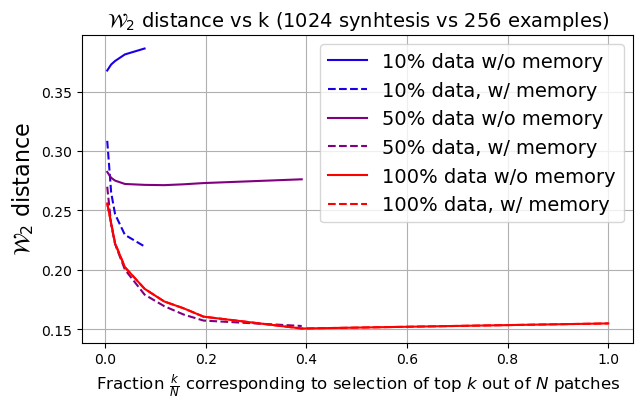

In [4]:
torch.manual_seed(0)
img = Tensor_load('results/red_peppers.jpg')

patchsize=16
stride=16    # non ovelapping

P_exmpl = Patch_extraction(img,patchsize=patchsize,stride=stride) 

lrs=[.1,.5,1]                     # list of ratios to explore
lk=[1,3,5,10,20,30,40,50,100,256] # list of k values to explor

plt.figure(figsize=(4*16/9,4))

for rs in tqdm(lrs):
    for memory in [0,1]:
        l=[]
        for k in lk:
            try:
                cost=0
                n_run=5 # average over 5 generations for each
                for seed in range(n_run):
                    synth=  Nifty(img,rs=rs,T=50,k=k,patchsize=patchsize,stride=stride,octaves=1,size=(512,512),renoise=0.5,show=False,memory=memory,warmup=0,seed=seed) 
                    P_synth = Patch_extraction(synth,patchsize, stride)
                    D=(P_exmpl[0]**2).sum(0,keepdim=True).T-2*P_exmpl[0].T@P_synth[0]+(P_synth[0]**2).sum(0,keepdim=True)   # Distance matrix
                    a = torch.ones(P_exmpl.shape[-1]).cuda() / P_exmpl.shape[-1]                                            # uniform distribution over patches
                    b = torch.ones(P_synth.shape[-1]).cuda() / P_synth.shape[-1]                                            # uniform distribution over patches
                    P = ot.emd(a, b, D)                                                                                     # exact OT plan
                    cost+=torch.sqrt(torch.sum(P * D)/P_synth.shape[-1]).cpu().numpy()                                      # OT cost
                l.append(cost/n_run)
            except:
                #print('Not enough reference patches to consider %d-NN after subsampling ratio %.1f'%(k,rs))
                pass # print commented for cleaner output
        plt.plot(np.array(lk[:len(l)])/P_exmpl.shape[-1],l,label='%d%% data%s'%(100*rs,', w/ memory' if memory else ' w/o memory'),linestyle='--' if memory else '-',color=(rs,0,1-rs))
    
plt.xlabel('Fraction $\\frac{k}{N}$ corresponding to selection of top $k$ out of $N$ patches',fontsize=12)
plt.ylabel('$\mathcal{W}_2$ distance',fontsize=16)
plt.title('$\mathcal{W}_2$ distance vs k (%d synhtesis vs %d examples)'%(P_synth.shape[-1],P_exmpl.shape[-1]),fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.grid()
plt.savefig('./results/rs_k_memory.pdf',bbox_inches='tight')
plt.show()
